### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'california_houses', # dataset name
    'source': 'kaggle',
    'competition': True,
    'remote_path': 'california-house-prices',
    'files': ['train.csv'],
    'rename_files': ['cf_house_train_processed.csv'],
    'task': 'reg',
    'target': 'Total interior livable area',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/california_houses.
Downloaded california_houses dataset to /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/california_houses


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:
# TODO: to get the dataset size to a reasonable size, we will downsample the .csv files
import os
import pandas as pd

# Define the path
current_dir = os.getcwd()
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

# File paths
train_path = os.path.join(download_path, dataset_config['rename_files'][0])

# Load safely, skipping bad lines
train_df = pd.read_csv(train_path, on_bad_lines='skip', engine='python')

# Downsample with fallback if not enough rows
train_sample_size = min(len(train_df), 12000)

train_df = train_df.sample(n=train_sample_size, random_state=42).reset_index(drop=True)

# Save back (overwrite the originals)
train_df.to_csv(train_path, index=False)

print(f"Downsampled {train_path} to {train_sample_size} rows.")


Downsampled /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/california_houses/cf_house_train_processed.csv to 11351 rows.


In [6]:
dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/california_houses/cf_house_train_processed.csv


,Column Name,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Last Sold Price,City,Zip
0,11535,The Villages 55+ Newly remodeled 2 bedroom gro...,Condo,1973.0,Central Forced Air - Gas,"Ceiling Fan, Central AC","Garage, Carport, Covered",NaN,More than One Bedroom on Ground Floor,1.0,1.0,913.0,1.0,1.0,6.0,1.8,8.0,1.6,8.0,3.5,"Tile, Hardwood, Carpet","Forced air, Gas",Central,"Dryer, Garbage disposal, Microwave, Range / Ov...","Coin Operated, Washer / Dryer, In Utility Room...","Garage, Carport, Covered",246920.0,3674.0,215000.0,San Jose,95135.0
1,6978,Stunning 2 bedroom/2 bath condo available now ...,Apartment,1987.0,"Forced air, Gas",Central,Garage,NaN,2,2.0,2.0,1048.0,0.0,0.0,4.0,0.5,3.0,1.6,5.0,1.7,"Tile, Laminate","Forced air, Gas",Central,"Dryer, Washer",In Unit,Garage,691906.0,8656.0,NaN,San Jose,95110.0
2,7086,Coming Soon Los Gatos Mountains Cottage tucked...,SingleFamily,1932.0,"Forced Air, Wall Furnace, Fireplace",NaN,"Garage, Off-street, Covered",26136.0,2,2.0,2.0,1285.0,5.0,5.0,6.0,1.5,9.0,3.0,10.0,3.9,Hardwood,Forced air,NaN,"Garbage disposal, Refrigerator",NaN,"Garage, Off-street, Covered",790500.0,9557.0,825000.0,Los Gatos,95033.0


In [7]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=0.5)
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index([], dtype='object')
Dataframe shape before/afrer cleaning: (11351, 31) / (11351, 31)


In [8]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['Id', 'Address', # non-informative
                'High School', 'Middle School', 'Elementary School', # too fined grained
                'State', 'Region', # only 2 states and region is redundant to ZIP,
                'Sold Price', 'Listed Price', # way to correlated to target
                'Last Sold On', 'Listed On' # last sold is often empty, listed on is 
    ]

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")


Column Id not found in dataframe
Column Address not found in dataframe
Column High School not found in dataframe
Column Middle School not found in dataframe
Column Elementary School not found in dataframe
Column State not found in dataframe
Column Region not found in dataframe
Column Sold Price not found in dataframe
Column Listed Price not found in dataframe
Column Last Sold On not found in dataframe
Column Listed On not found in dataframe
Dataframe shape before/afrer by-hand cleaning: (11351, 31) / (11351, 31)


In [9]:
# TODO: some custom data cleaning

import copy 
tmp_df = copy.deepcopy(dataset_files_cleaned)

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    
    if 'Last Sold On' in df_file.columns:
        # convert to datetime
        df_file['Last Sold On'] = pd.to_datetime(df_file['Last Sold On'], format='%Y-%m-%d')
        # convert to seconds
        df_file['Last Sold On'] = df_file['Last Sold On'].astype('int64') / 1e9

    if 'Listed On' in df_file.columns:
        df_file['Last Sold On'] = pd.to_datetime(df_file['Last Sold On'], format='%Y-%m-%d')
        df_file['Last Sold On'] = df_file['Last Sold On'].astype('int64') / 1e9  # nanoseconds to seconds

    print(f"Dataframe shape after custom clearning: {df_file.shape}")

display(dataset_files_cleaned[0].head(n=3))

dataset_files_by_hand_cleaned = dataset_files_cleaned

dataset_files_cleaned = tmp_df

Dataframe shape before custom cleaning: (11351, 31)
Dataframe shape after custom clearning: (11351, 31)


,Column Name,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Last Sold Price,City,Zip
0,11535,The Villages 55+ Newly remodeled 2 bedroom gro...,Condo,1973.0,Central Forced Air - Gas,"Ceiling Fan, Central AC","Garage, Carport, Covered",NaN,More than One Bedroom on Ground Floor,1.0,1.0,913.0,1.0,1.0,6.0,1.8,8.0,1.6,8.0,3.5,"Tile, Hardwood, Carpet","Forced air, Gas",Central,"Dryer, Garbage disposal, Microwave, Range / Ov...","Coin Operated, Washer / Dryer, In Utility Room...","Garage, Carport, Covered",246920.0,3674.0,215000.0,San Jose,95135.0
1,6978,Stunning 2 bedroom/2 bath condo available now ...,Apartment,1987.0,"Forced air, Gas",Central,Garage,NaN,2,2.0,2.0,1048.0,0.0,0.0,4.0,0.5,3.0,1.6,5.0,1.7,"Tile, Laminate","Forced air, Gas",Central,"Dryer, Washer",In Unit,Garage,691906.0,8656.0,NaN,San Jose,95110.0
2,7086,Coming Soon Los Gatos Mountains Cottage tucked...,SingleFamily,1932.0,"Forced Air, Wall Furnace, Fireplace",NaN,"Garage, Off-street, Covered",26136.0,2,2.0,2.0,1285.0,5.0,5.0,6.0,1.5,9.0,3.0,10.0,3.9,Hardwood,Forced air,NaN,"Garbage disposal, Refrigerator",NaN,"Garage, Off-street, Covered",790500.0,9557.0,825000.0,Los Gatos,95033.0


### Now it is time to visualize our changes

In [10]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,Column Name,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Last Sold Price,City,Zip
0,11535,The Villages 55+ Newly remodeled 2 bedroom gro...,Condo,1973.0,Central Forced Air - Gas,"Ceiling Fan, Central AC","Garage, Carport, Covered",NaN,More than One Bedroom on Ground Floor,1.0,1.0,913.0,1.0,1.0,6.0,1.8,8.0,1.6,8.0,3.5,"Tile, Hardwood, Carpet","Forced air, Gas",Central,"Dryer, Garbage disposal, Microwave, Range / Ov...","Coin Operated, Washer / Dryer, In Utility Room...","Garage, Carport, Covered",246920.0,3674.0,215000.0,San Jose,95135.0
1,6978,Stunning 2 bedroom/2 bath condo available now ...,Apartment,1987.0,"Forced air, Gas",Central,Garage,NaN,2,2.0,2.0,1048.0,0.0,0.0,4.0,0.5,3.0,1.6,5.0,1.7,"Tile, Laminate","Forced air, Gas",Central,"Dryer, Washer",In Unit,Garage,691906.0,8656.0,NaN,San Jose,95110.0
2,7086,Coming Soon Los Gatos Mountains Cottage tucked...,SingleFamily,1932.0,"Forced Air, Wall Furnace, Fireplace",NaN,"Garage, Off-street, Covered",26136.0,2,2.0,2.0,1285.0,5.0,5.0,6.0,1.5,9.0,3.0,10.0,3.9,Hardwood,Forced air,NaN,"Garbage disposal, Refrigerator",NaN,"Garage, Off-street, Covered",790500.0,9557.0,825000.0,Los Gatos,95033.0


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [11]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    # numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)


Threshold for categorical vs textual: 567
Numerical columns (18): ['Column Name', 'Year built', 'Lot', 'Bathrooms', 'Full bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Last Sold Price', 'Zip']
Categorical columns (5): ['Type', 'Cooling', 'Bedrooms', 'Heating features', 'Cooling features']
Textual columns (8): ['Summary', 'Heating', 'Parking', 'Flooring', 'Appliances included', 'Laundry features', 'Parking features', 'City']



Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [12]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

pd.set_option('display.max_rows', None)
display(summary_df)  # Or print(summary_df)

,Column Name,Example Value,Type,# Categories
0,Column Name,11535,numerical,~ 11351 ~
1,Summary,The Villages 55+ Newly remodeled 2 bedroom gro...,textual,11258
2,Type,Condo,categorical,51
3,Year built,1973.0,numerical,~ 143 ~
4,Heating,Central Forced Air - Gas,textual,786
5,Cooling,"Ceiling Fan, Central AC",categorical,264
6,Parking,"Garage, Carport, Covered",textual,1738
7,Lot,26136.0,numerical,~ 3705 ~
8,Bedrooms,More than One Bedroom on Ground Floor,categorical,156
9,Bathrooms,1.0,numerical,~ 17 ~


#### We also need to make sure that numerical columns are actually numerical :)

In [13]:
import re
import pandas as pd
import copy

from dataloader_functions.load_and_pp_raw_data import clean_numerical_columns

summary_df, dataset_files_by_hand_cleaned = clean_numerical_columns(summary_df, dataset_files_by_hand_cleaned)

pd.set_option('display.max_rows', None)
display(summary_df)


Column 'Column Name' requires cleaning (non-numeric artifacts found).
Column 'Year built' requires cleaning (non-numeric artifacts found).
Column 'Lot' requires cleaning (non-numeric artifacts found).
Column 'Bathrooms' requires cleaning (non-numeric artifacts found).
Column 'Full bathrooms' requires cleaning (non-numeric artifacts found).
Column 'Total interior livable area' requires cleaning (non-numeric artifacts found).
Column 'Total spaces' requires cleaning (non-numeric artifacts found).
Column 'Garage spaces' requires cleaning (non-numeric artifacts found).
Column 'Elementary School Score' requires cleaning (non-numeric artifacts found).
Column 'Elementary School Distance' requires cleaning (non-numeric artifacts found).
Column 'Middle School Score' requires cleaning (non-numeric artifacts found).
Column 'Middle School Distance' requires cleaning (non-numeric artifacts found).
Column 'High School Score' requires cleaning (non-numeric artifacts found).
Column 'High School Distanc

,Column Name,Example Value,Type,# Categories
0,Column Name,11535.0,numerical,11349
1,Summary,The Villages 55+ Newly remodeled 2 bedroom gro...,textual,11258
2,Type,Condo,categorical,51
3,Year built,1973.0,numerical,142
4,Heating,Central Forced Air - Gas,textual,786
5,Cooling,"Ceiling Fan, Central AC",categorical,264
6,Parking,"Garage, Carport, Covered",textual,1738
7,Lot,26136.0,numerical,3704
8,Bedrooms,More than One Bedroom on Ground Floor,categorical,156
9,Bathrooms,1.0,numerical,16


#### We also need to make sure that numerical columns are actually numerical :)

In [14]:
import re
import pandas as pd
import copy

from dataloader_functions.load_and_pp_raw_data import clean_numerical_columns

summary_df, dataset_files_by_hand_cleaned = clean_numerical_columns(summary_df, dataset_files_by_hand_cleaned)

pd.set_option('display.max_rows', None)
display(summary_df)


,Column Name,Example Value,Type,# Categories
0,Column Name,11535.0,numerical,11349
1,Summary,The Villages 55+ Newly remodeled 2 bedroom gro...,textual,11258
2,Type,Condo,categorical,51
3,Year built,1973.0,numerical,142
4,Heating,Central Forced Air - Gas,textual,786
5,Cooling,"Ceiling Fan, Central AC",categorical,264
6,Parking,"Garage, Carport, Covered",textual,1738
7,Lot,26136.0,numerical,3704
8,Bedrooms,More than One Bedroom on Ground Floor,categorical,156
9,Bathrooms,1.0,numerical,16


### Saving the processed data and loading it back up

In [15]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{file_base}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/california_houses/cf_house_train_processed_processed.pkl


In [16]:
import os
import pandas as pd

# Loop through processed files in rename_files
for file_name in dataset_config['rename_files']:
    # Remove .csv or .tsv extension to get the base name
    file_base = os.path.splitext(file_name)[0]
    processed_filename = f"{file_base}_processed.pkl"
    processed_path = os.path.join(download_path, processed_filename)

    # Load the bundled dictionary (data + summary + config)
    bundle = pd.read_pickle(processed_path)

    # Extract components
    loaded_df = bundle['data']
    loaded_df.to_csv('cf_house_train_processed.csv')
    summary_df = bundle['summary']
    loaded_config = bundle['config']

    print(f"\n=== {file_base.upper()} ===")
    print(f"Loaded config keys: {list(loaded_config.keys())}")

    # Show metadata
    meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
    display(meta_df)

    # Flatten for modeling
    loaded_df.columns = loaded_df.columns.get_level_values(0)
    display(loaded_df.head(n=3))



=== CF_HOUSE_TRAIN_PROCESSED ===
Loaded config keys: ['dataset_name', 'source', 'competition', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,Column Name,numerical,11349
1,Summary,textual,11258
2,Type,categorical,51
3,Year built,numerical,142
4,Heating,textual,786
5,Cooling,categorical,264
6,Parking,textual,1738
7,Lot,numerical,3704
8,Bedrooms,categorical,156
9,Bathrooms,numerical,16


Column Name,Column Name,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Last Sold Price,City,Zip
0,11535.0,The Villages 55+ Newly remodeled 2 bedroom gro...,Condo,1973.0,Central Forced Air - Gas,"Ceiling Fan, Central AC","Garage, Carport, Covered",NaN,More than One Bedroom on Ground Floor,1.0,1.0,913.0,1.0,1.0,6.0,1.8,8.0,1.6,8.0,3.5,"Tile, Hardwood, Carpet","Forced air, Gas",Central,"Dryer, Garbage disposal, Microwave, Range / Ov...","Coin Operated, Washer / Dryer, In Utility Room...","Garage, Carport, Covered",246920.0,3674.0,215000.0,San Jose,95135.0
1,6978.0,Stunning 2 bedroom/2 bath condo available now ...,Apartment,1987.0,"Forced air, Gas",Central,Garage,NaN,2,2.0,2.0,1048.0,0.0,0.0,4.0,0.5,3.0,1.6,5.0,1.7,"Tile, Laminate","Forced air, Gas",Central,"Dryer, Washer",In Unit,Garage,691906.0,8656.0,NaN,San Jose,95110.0
2,7086.0,Coming Soon Los Gatos Mountains Cottage tucked...,SingleFamily,1932.0,"Forced Air, Wall Furnace, Fireplace",NaN,"Garage, Off-street, Covered",26136.0,2,2.0,2.0,1285.0,5.0,5.0,6.0,1.5,9.0,3.0,10.0,3.9,Hardwood,Forced air,NaN,"Garbage disposal, Refrigerator",NaN,"Garage, Off-street, Covered",790500.0,9557.0,825000.0,Los Gatos,95033.0


### Bonus insights (Regression)

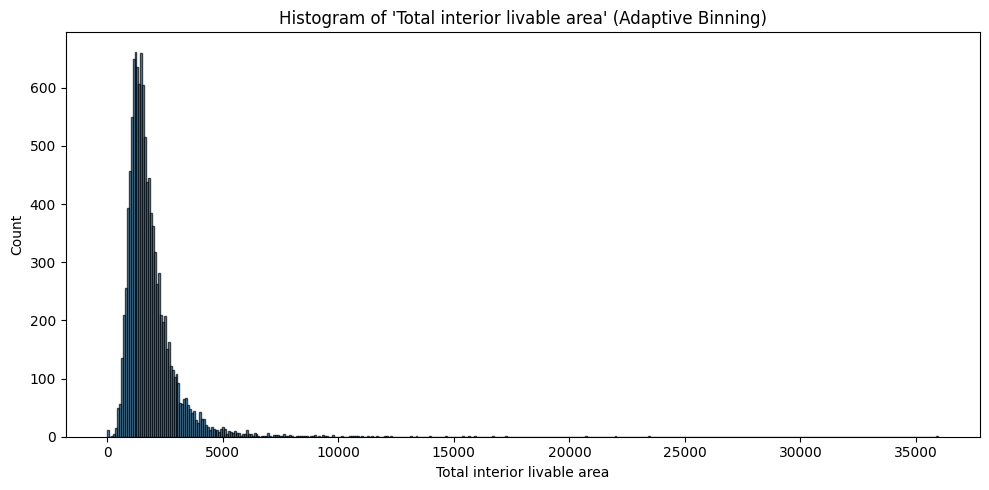

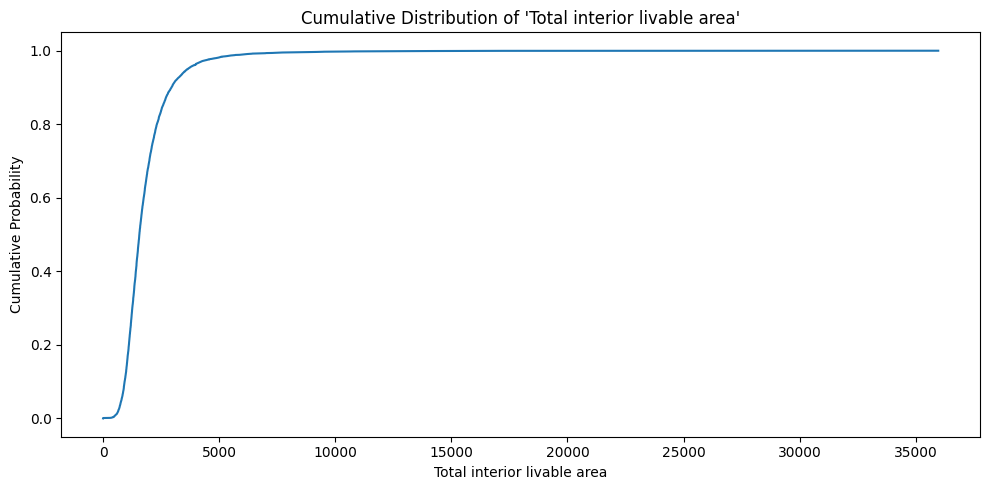

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get target series
target_series = loaded_df[dataset_config['target']].dropna()

# 1️⃣ Histogram with Freedman-Diaconis rule for binning
q25, q75 = np.percentile(target_series, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * len(target_series) ** (-1/3)
bin_count = int((target_series.max() - target_series.min()) / bin_width)
bin_count = max(10, bin_count)  # Ensure reasonable minimum bin count

plt.figure(figsize=(10, 5))
plt.hist(target_series, bins=bin_count, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of '{dataset_config['target']}' (Adaptive Binning)")
plt.xlabel(dataset_config['target'])
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2️⃣ Cumulative Distribution Function (CDF)
target_sorted = target_series.sort_values()
cdf = np.arange(len(target_sorted)) / len(target_sorted)

plt.figure(figsize=(10, 5))
plt.plot(target_sorted, cdf, color='tab:blue')
plt.title(f"Cumulative Distribution of '{dataset_config['target']}'")
plt.xlabel(dataset_config['target'])
plt.ylabel('Cumulative Probability')
plt.tight_layout()
plt.show()


In [18]:
from baseline_eval import evaluate_baseline, plot_model_performance_summary
results = evaluate_baseline(
    df=loaded_df,
    model='AGTabular',
    df_name=dataset_config['dataset_name'],
    label_col= dataset_config['target'],
    task_type=dataset_config['task'],
    textual_cols=textual_cols,
    k_folds=5,
    seed=0,
    max_samples=3000,
    output_path=f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250521_141957"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #53~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jan 15 19:18:46 UTC 2
CPU Count:          64
Memory Avail:       360.94 GB / 503.54 GB (71.7%)
Disk Space Avail:   33801.48 GB / 51214.59 GB (66.0%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1



[WRAPPER] Running stratified downsampling mode for task: reg
Info: 
[INFO] Downsampling dataframe: california_houses (original rows: 11351)
Downsampled 3000 rows for california_houses dataset.


Beginning AutoGluon training ... Time limit = 360s
AutoGluon will save models to "/home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/AutogluonModels/ag-20250521_141957"
Train Data Rows:    2400
Train Data Columns: 30
Label Column:       Total interior livable area
Problem Type:       regression
Preprocessing data ...
/work/dlclarge2/guptaa-dataset/anshul_env/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:351: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[self.label] = X[self.label].replace([np.inf, -np.inf], np.nan)
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    366894.04 MB
	Train Data (Original)  Memory Usage: 4.95 MB (0.0% of a

In [19]:
rs = pd.read_csv(f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv")
plot_model_performance_summary(name=dataset_config['dataset_name'],task=dataset_config['task'], df=rs)

Saving plot to ../../baseline_results/plots/reg/score
Saving plot to ../../baseline_results/plots/reg/loss
Saving plot to ../../baseline_results/plots/reg/roc_auc


{'score':                                     mean       std
 model                                             
 AutoGluon_Tabular_with_text     0.537332  0.154863
 AutoGluon_Tabular_without_text  0.626150  0.120773,
 'loss':                                       mean         std
 model                                                 
 AutoGluon_Tabular_without_text  780.180157  336.169822
 AutoGluon_Tabular_with_text     874.170422  397.501726,
 'roc_auc':                                 mean  std
 model                                    
 AutoGluon_Tabular_with_text      NaN  NaN
 AutoGluon_Tabular_without_text   NaN  NaN}